<a href="https://colab.research.google.com/github/Ghonem22/Action-Detection/blob/master/action_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Summary

This project is based on "i3d-kinetics-400" module which is described in this paper "https://arxiv.org/abs/1705.07750". The original model is Kinetics which was trained using  kinetics-400 dateset, but then it was fine tuned using UCF101 and HMDB51 datasets.
this is the labels of the model:
https://github.com/deepmind/kinetics-i3d/blob/master/data/label_map.txt


#import && install required libraries

In [0]:
# Install the necessary python packages.
!pip install -q "tensorflow>=1.7" "tensorflow-hub" "imageio"

In [0]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
import tensorflow as tf
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

#Helper functions to fetch videos from UCF101 dataset

In [0]:
UCF_ROOT = "http://crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetchs a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]
#convert vedio into frames
def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

#to display the frames of the vedio as animation
def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))

In [8]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


In [9]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()
  
categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))


Found 13320 videos in 101 categories.
ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking              

#upload the vedio u wanna test

Fetching http://crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_JumpingJack_g01_c02.avi => /tmp/tmprl6da0bh/v_JumpingJack_g01_c02.avi
sample_video is a numpy array of shape (91, 224, 224, 3).


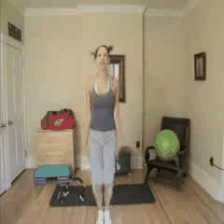

In [15]:
# Get a sample cricket video.
sample_video = load_video(fetch_ucf_video("v_JumpingJack_g01_c02.avi"))

print("sample_video is a numpy array of shape %s." % str(sample_video.shape))
animate(sample_video)

#import the "i3d-kinetics" model, and use it for detect the action at our vedio

In [16]:
# Run the i3d model on the video and print the top 5 actions.

# First add an empty dimension to the sample video as the model takes as input
# a batch of videos.
model_input = np.expand_dims(sample_video, axis=0)

# Create the i3d model and get the action probabilities.
with tf.Graph().as_default():
  i3d = hub.Module("https://tfhub.dev/deepmind/i3d-kinetics-400/1")
  input_placeholder = tf.placeholder(shape=(None, None, 224, 224, 3), dtype=tf.float32)
  logits = i3d(input_placeholder)
  probabilities = tf.nn.softmax(logits)
  with tf.train.MonitoredSession() as session:
    [ps] = session.run(probabilities,
                       feed_dict={input_placeholder: model_input})

print("Top 5 actions:")
for i in np.argsort(ps)[::-1][:5]:
  print("%-22s %.2f%%" % (labels[i], ps[i] * 100))

Top 5 actions:
doing aerobics         57.75%
dancing ballet         10.44%
zumba                  7.93%
lunge                  6.51%
high kick              4.35%
